Net(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=62, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (reluAct): ReLU()
  (tanAct): Tanh()
)
Fold 1/20
Fold [1/20], Train loss: 0.6185, Val loss: 1.2380


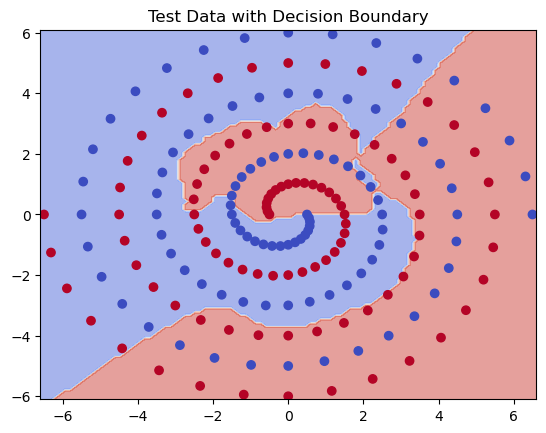

Fold 2/20
Fold [2/20], Train loss: 0.5168, Val loss: 1.6536


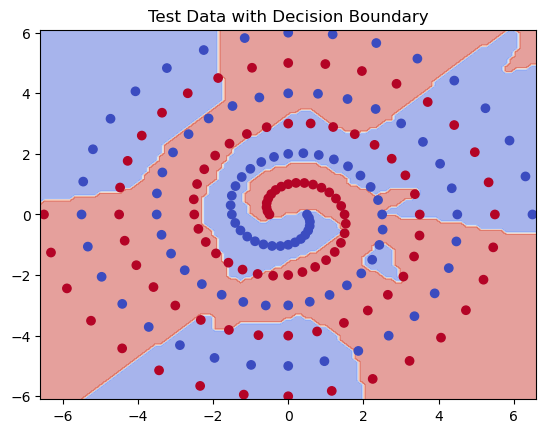

Fold 3/20
Fold [3/20], Train loss: 0.4518, Val loss: 0.7915


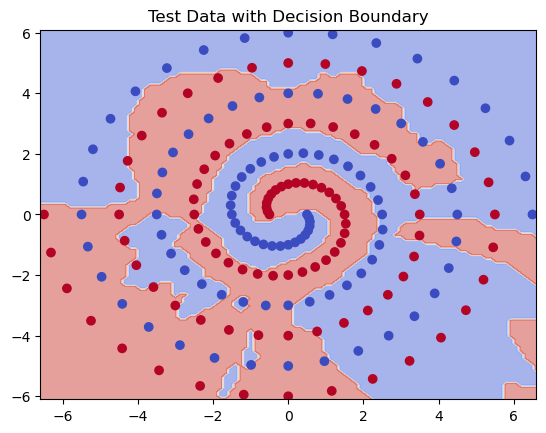

Fold 4/20
Fold [4/20], Train loss: 0.3218, Val loss: 3.1113


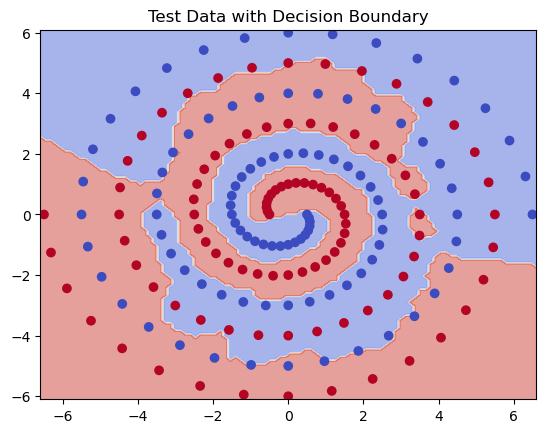

Fold 5/20
Fold [5/20], Train loss: 0.2673, Val loss: 4.9041


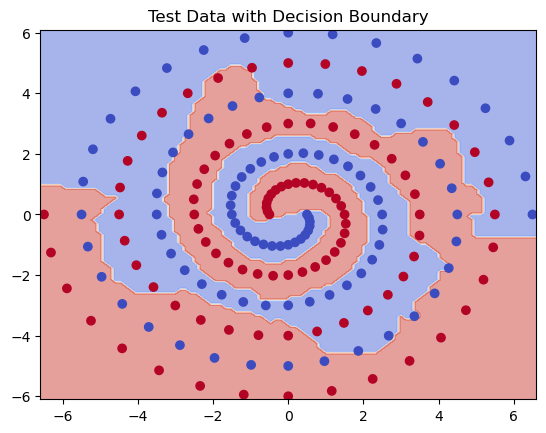

Fold 6/20
Fold [6/20], Train loss: 0.2413, Val loss: 4.6056


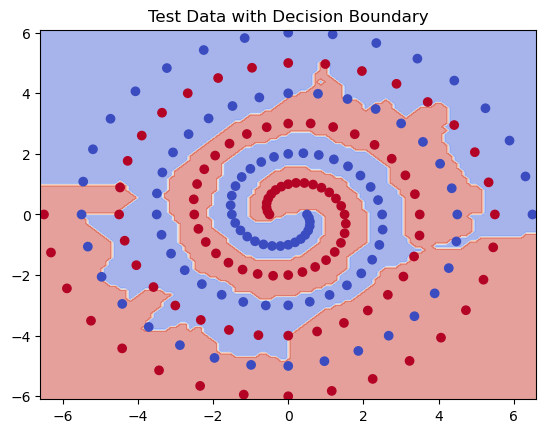

Fold 7/20
Fold [7/20], Train loss: 0.1976, Val loss: 3.2061


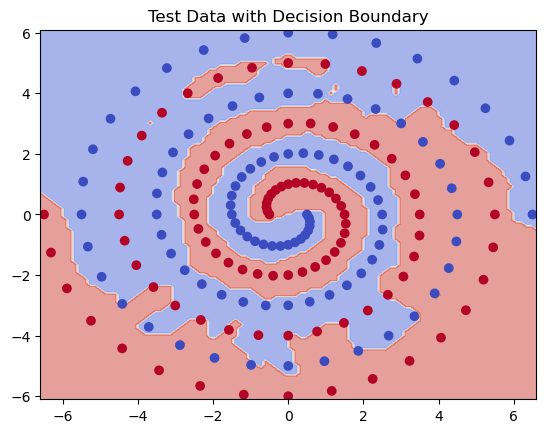

Fold 8/20
Fold [8/20], Train loss: 0.1477, Val loss: 3.4194


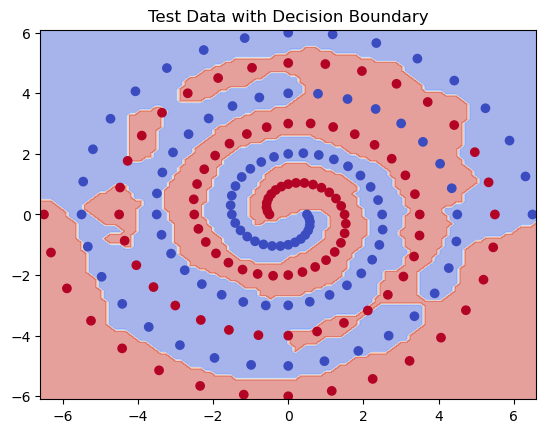

Fold 9/20
Fold [9/20], Train loss: 0.0938, Val loss: 2.8544


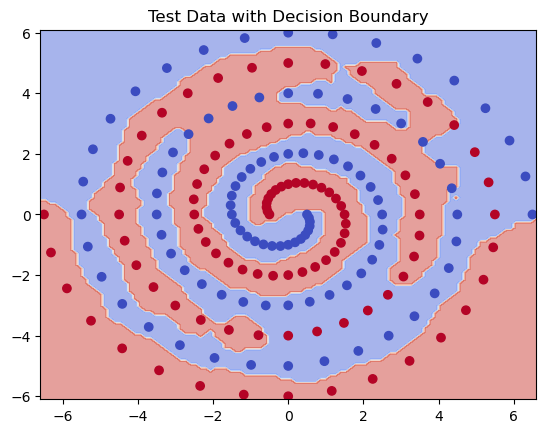

Fold 10/20
Fold [10/20], Train loss: 0.0648, Val loss: 0.5833


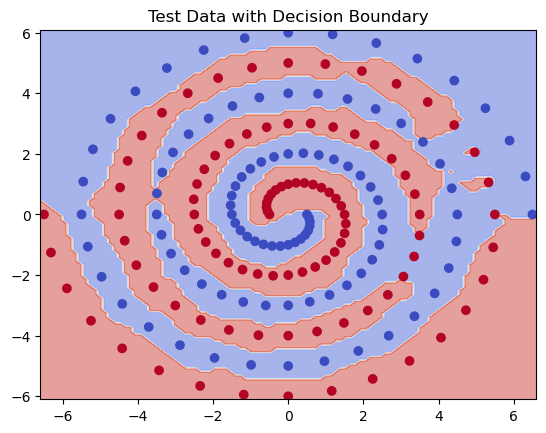

Fold 11/20
Fold [11/20], Train loss: 0.0343, Val loss: 0.3692


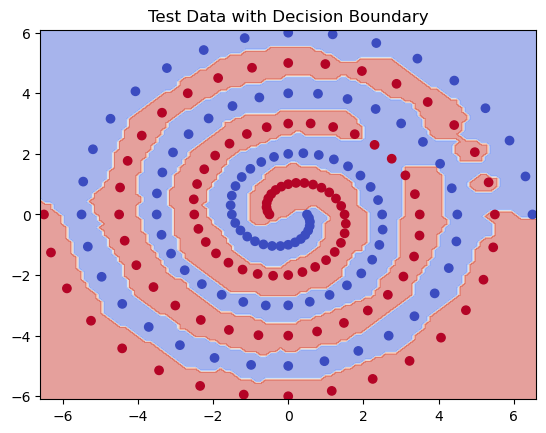

Fold 12/20
Fold [12/20], Train loss: 0.0212, Val loss: 0.0835


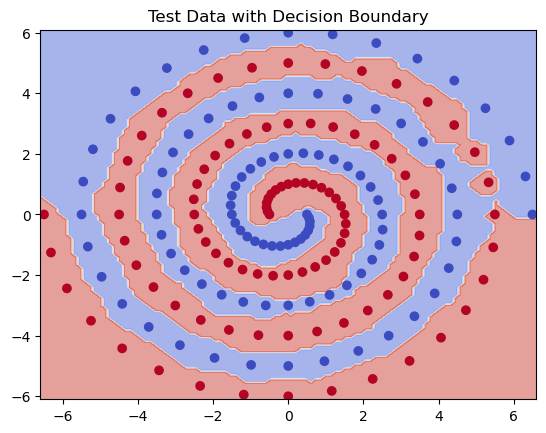

Fold 13/20
Fold [13/20], Train loss: 0.0139, Val loss: 0.0083


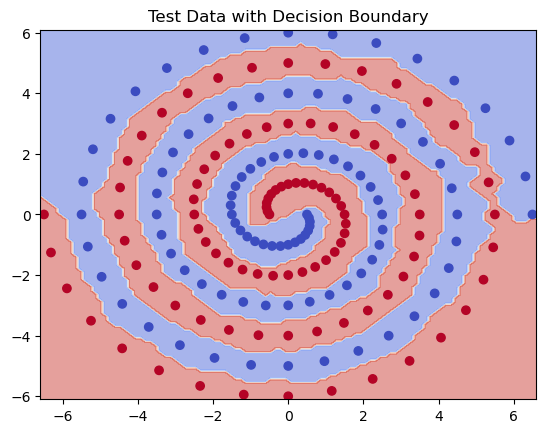

Fold 14/20
Fold [14/20], Train loss: 0.0096, Val loss: 0.0014


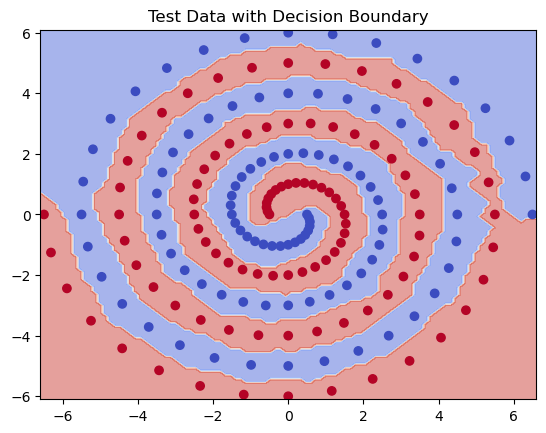

Fold 15/20
Fold [15/20], Train loss: 0.0068, Val loss: 0.0023


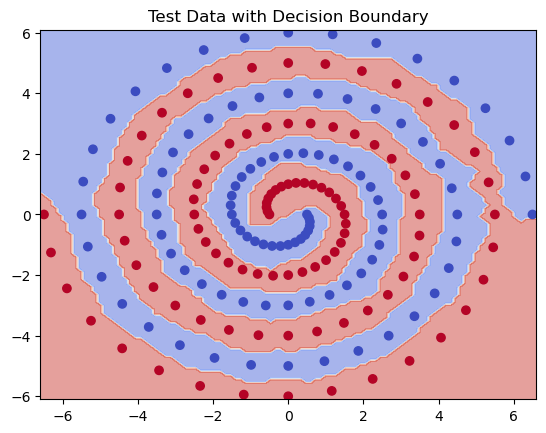

Fold 16/20
Fold [16/20], Train loss: 0.0050, Val loss: 0.0007


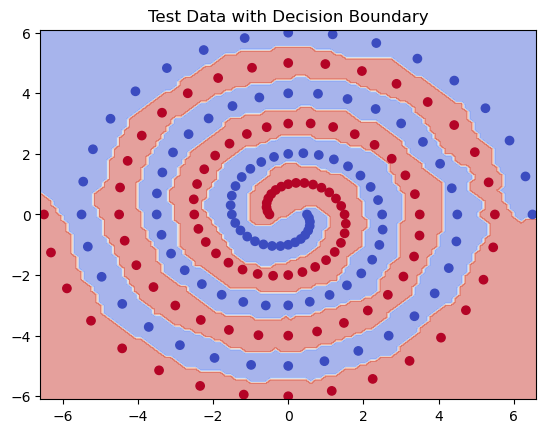

Fold 17/20
Fold [17/20], Train loss: 0.0037, Val loss: 0.0016


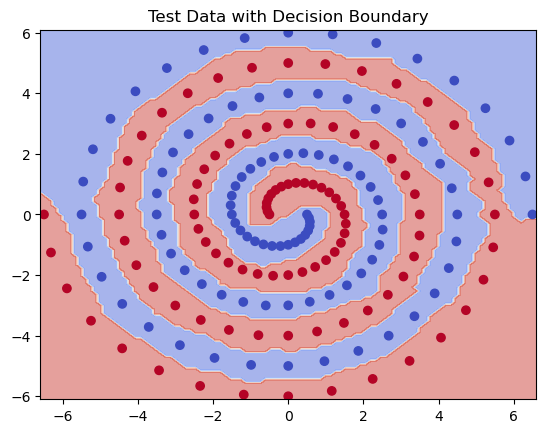

Fold 18/20
Fold [18/20], Train loss: 0.0029, Val loss: 0.0002


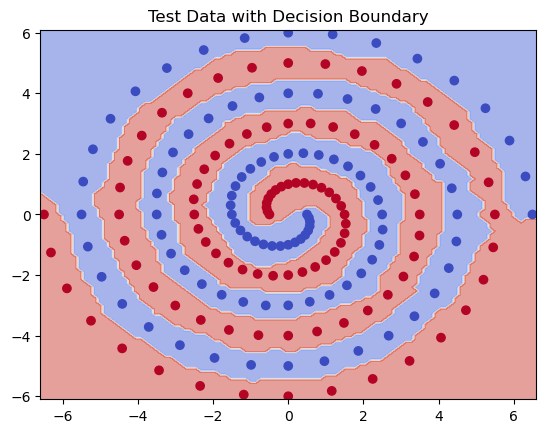

Fold 19/20
Fold [19/20], Train loss: 0.0024, Val loss: 0.0000


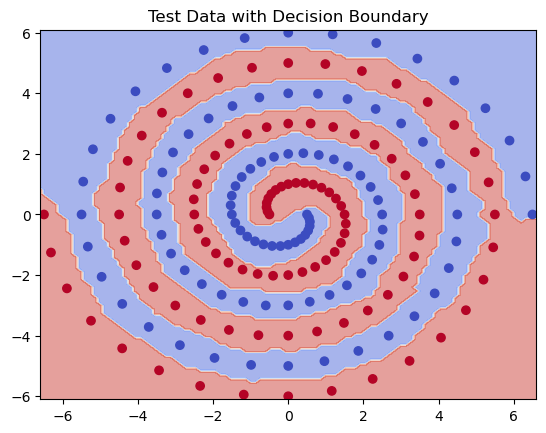

Fold 20/20
Fold [20/20], Train loss: 0.0019, Val loss: 0.0011


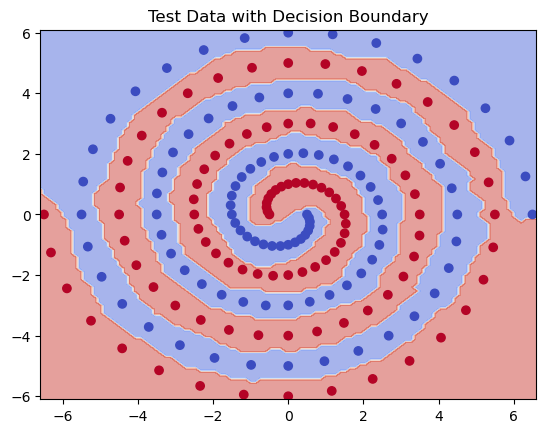

Average train loss: 0.1512, Average val loss: 1.3418


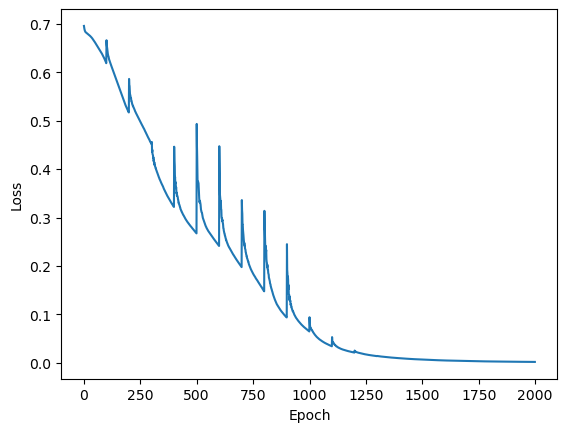

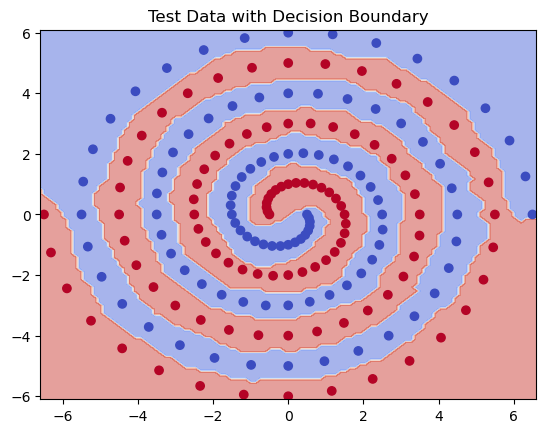

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Load the dataset
# torch.manual_seed(42)

data = pd.read_csv('datasets/spiralsdataset.csv', header=None, names=['x1', 'x2', 'y'])
# Split the dataset into features and labels
X = data[['x1', 'x2']].to_numpy()
y = data['y'].to_numpy()
# Convert the labels to one-hot encoding
y = np.eye(2)[y]
# Define the FFNN architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.fc3 = nn.Linear(hidden_size, hidden_size-2, bias=True)
        self.fc4 = nn.Linear(hidden_size, output_size, bias=True)
        self.reluAct = nn.ReLU()
        self.tanAct = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.reluAct(x)
        x = self.fc2(x)
        x = self.reluAct(x)
        x = self.fc2(x)
        x = self.reluAct(x)
        # x = self.fc2(x)
        # x = self.tanAct(x)
        # x = self.fc2(x)
        # x = self.tanAct(x)
        x = self.fc4(x)
        x = nn.Softmax(dim=1)(x)
        return x

# Set the hyperparameters
input_size = 2
hidden_size = 64
output_size = 2
learning_rate = 0.001
num_epochs = 100
num_folds = 20

# Create the FFNN
net = Net(input_size, hidden_size, output_size)
print(net)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Perform k-fold cross-validation
kf = KFold(n_splits=num_folds)
loss_list = []
train_acc_list = []
test_acc_list = []
train_losses = []
val_losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the dataset into training and test data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Convert the training and test data to PyTorch tensors
    x_train = torch.from_numpy(X_train).type(torch.float32)
    x_test = torch.from_numpy(X_test).type(torch.float32)
    y_train = torch.from_numpy(y_train).type(torch.float32)
    y_test = torch.from_numpy(y_test).type(torch.float32)

# Train the FFNN
    for epoch in range(num_epochs):
        # Forward pass
        outputs = net(x_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss for this epoch
        loss_list.append(loss.item())
            # Save the training and validation losses for this fold
    train_losses.append(loss_list[-1])
    val_loss = criterion(net(x_test), y_test)
    val_losses.append(val_loss.item())

    # Print the training and validation loss for this fold
    print('Fold [{}/{}], Train loss: {:.4f}, Val loss: {:.4f}'
    .format(fold+1, num_folds, train_losses[-1], val_losses[-1]))
    x1_min, x1_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    x2_min, x2_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = torch.meshgrid(torch.linspace(x1_min, x1_max, 100),
                            torch.linspace(x2_min, x2_max, 100))
    X_grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)), dim=1)
    
    # Get the predicted class labels for the grid points
    with torch.no_grad():
        grid_outputs = net(X_grid)
        grid_predicted = torch.argmax(grid_outputs, dim=1)
    # Plot the decision boundary
    plt.contourf(xx, yy, grid_predicted.reshape(xx.shape), cmap='coolwarm', alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y.argmax(axis=1), cmap='coolwarm')
    plt.title('Test Data with Decision Boundary')
    plt.show()

# Calculate the average training and validation loss across all folds
avg_train_loss = sum(train_losses) / num_folds
avg_val_loss = sum(val_losses) / num_folds
print('Average train loss: {:.4f}, Average val loss: {:.4f}'
      .format(avg_train_loss, avg_val_loss))
    
# Plot the loss
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the dataset with the predicted classes
x1_min, x1_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
x2_min, x2_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
xx, yy = torch.meshgrid(torch.linspace(x1_min, x1_max, 100),
                         torch.linspace(x2_min, x2_max, 100))
X_grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1)), dim=1)
# Get the predicted class labels for the grid points
with torch.no_grad():
    grid_outputs = net(X_grid)
    grid_predicted = torch.argmax(grid_outputs, dim=1)
# Plot the decision boundary
plt.contourf(xx, yy, grid_predicted.reshape(xx.shape), cmap='coolwarm', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y.argmax(axis=1), cmap='coolwarm')
plt.title('Test Data with Decision Boundary')
plt.show()
